In [1]:
#Gerekli Kütüphanelerin import edilmesi

import numpy as np
import pandas as pd

#-----------------------Heatmap Oluşturmak İçin Kütüphane---------------------------------
import seaborn as sns

#------------------------Kelime Bulutu Oluşturmak ve Gerekli Görseller İçin Kütüphaneler---------------------------------
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline


import re

#NLTK İle Son Bir Ön İşleme Yapılması İçin Kütüphaneler
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#train_test_split
from sklearn.model_selection import train_test_split

#TF-IDF verileri vektör haline getirmek için kütüphane
from sklearn.feature_extraction.text import TfidfVectorizer
#Word2Vec bir diğer verileri vektör haline getirmek için kullanacağımız kütüphane
from gensim.models import Word2Vec


#------------------------Derste Gösterilen Makine Öğrenim Algoritması 1 için Kütüphane (MULTINOMIAL NAIVE-BAYES)---------------------------------
from sklearn.naive_bayes import MultinomialNB

#------------------------Derste Gösterilmeyen Makine Öğrenim 1 Algoritması için Kütüphane (RANDOM FOREST)---------------------------------
from sklearn.ensemble import RandomForestClassifier

#------------------------Derste Gösterilmeyen Makine Öğrenim 2 Algoritması için Kütüphane (LOGISTIC REGRESSION)---------------------------------
from sklearn.linear_model import LogisticRegression
#------------------------Derste Gösterilen Tek Katmanlı Yapay Sinir Ağı Algoritması için Kütüphane (PERCEPTRON)---------------------------------
from sklearn.neural_network import MLPClassifier

#------------------------Modellerin Başarılarını Ölçmek İçin Gerekli Kütüphaneler (ACCURACY-F1-RECALL-PRECISION)---------------------------------
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score



#------------------------Saçmasapan Uyarıların(-_-)Gösterilmemesi İçin Kütüphane---------------------------------
import warnings
warnings.filterwarnings("ignore")
#------------------------Google Drive Üzerinden CSV'yi Çekebilmek İçin Kütüphane---------------------------------
from google.colab import drive 
drive.mount('/content/gdrive')
data=pd.read_csv('gdrive/My Drive/bbc-haberler.csv')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Mounted at /content/gdrive


Veri seti yapısı:  (2225, 2) 

 Veri Setindeki Sütunlar:  Index(['haberTuru', 'haberIcerigi;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;'], dtype='object') 

 Haber Kategorileri:  ['tech' 'business' 'sport' 'entertainment' 'politics'] 




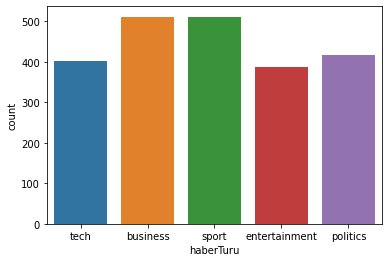

In [2]:
# verisetinin genel bilgilerini yazdırmak ve örneklemeK
print('Veri seti yapısı: ', data.shape, '\n\n Veri Setindeki Sütunlar: ',data.columns, '\n\n Haber Kategorileri: ', data.haberTuru.unique(), '\n\n')

# her haber türünden kaç tane olduğunu grafiğe dökmek
sns.countplot(data.haberTuru)

Veri setimde haber içeriklerimin olduğu bölüm isminde sıkıntı çıkıyor sebebini anlayamadım. Şu şekilde bir ismi oluyor: haberIcerigi;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;; 
halbuki noktalı virgüller yok boşluk var.

Haber İçeriklerinden Oluşturulmuş Kelime Bulutu: 


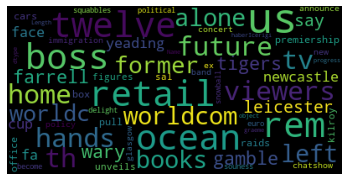



Haber Türlerinden Oluşturulmuş Kelime Bulutu: 


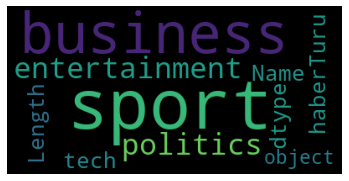

In [6]:
#Kelime Bulutları Oluşturmak
wordcloud = WordCloud(max_font_size=50,random_state=42).generate(str(data['haberIcerigi;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;']))
wordcloud2 = WordCloud(random_state=122).generate(str(data['haberTuru']))


plt.imshow(wordcloud)
plt.axis('off')
print("Haber İçeriklerinden Oluşturulmuş Kelime Bulutu: ")
plt.show()
plt.imshow(wordcloud2)
plt.axis('off')
print("\n\nHaber Türlerinden Oluşturulmuş Kelime Bulutu: ")
plt.show()

In [9]:
# Kelimeleri Token Haline Getirmek(Kelime kelime, cümle cümle şeklinde ayırmak)
data['temizlenmis'] = data['haberIcerigi;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;'].apply(nltk.word_tokenize)


# Kelimelerin Yalnızca Köklerini Bırakmak
lem = nltk.stem.wordnet.WordNetLemmatizer()
data['temizlenmis'] = data['temizlenmis'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Son Önişleme İşlemi Bitti')

Son Önişleme İşlemi Bitti




 Perceptron :
Accuracy Puanı: 0.508 
Precision Puanı: 0.502 
Recall Puanı: 0.504 
F1 Puanı: 0.485



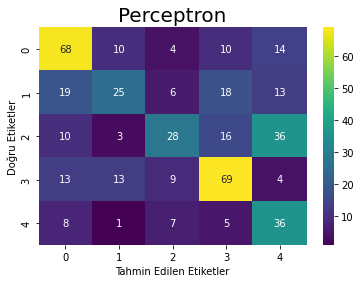



 RandomForest :
Accuracy Puanı: 0.587 
Precision Puanı: 0.572 
Recall Puanı: 0.583 
F1 Puanı: 0.574



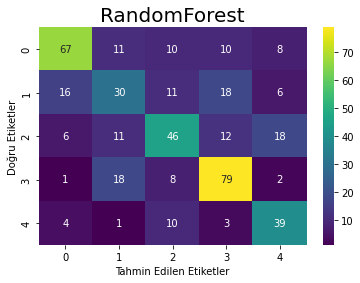



 LogisticRegression :
Accuracy Puanı: 0.528 
Precision Puanı: 0.551 
Recall Puanı: 0.527 
F1 Puanı: 0.500



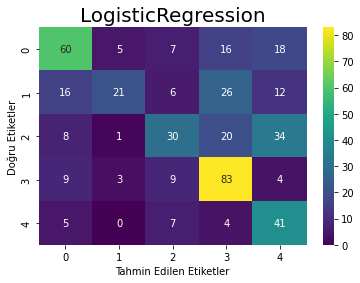

In [22]:
#Word2Vec Vectorizer kullanarak temizlenmiş verileri vektör haline getirme(bu kısmı internet ortamından alıp kendi kodlarıma ve csv dosyama uyarladım)

vec_model = Word2Vec(data['temizlenmis'])
w2v = dict(zip(vec_model.wv.index2word , vec_model.wv.vectors))

class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])

class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)

model = { 'Perceptron': MLPClassifier(),'RandomForest': RandomForestClassifier(),'LogisticRegression': LogisticRegression()}
modelin_parametreleri = {'Perceptron': { 'activation': ['tanh', 'relu'] },'RandomForest': {},'LogisticRegression': {}}

X_train, X_test, y_train, y_test = train_test_split(data['haberIcerigi;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;'], data['haberTuru'], test_size=0.2, shuffle=True)

for key in model.keys():
    clf = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(model[key], modelin_parametreleri[key]))])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("\n\n",key, ':')
    print("Accuracy Puanı: %1.3f \nPrecision Puanı: %1.3f \nRecall Puanı: %1.3f \nF1 Puanı: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    plt.figure()
    sns.heatmap(confusion_matrix(y_test,y_pred),cmap='viridis',annot=True);
    plt.title(key, fontsize = 20)
    plt.xlabel("Tahmin Edilen Etiketler")
    plt.ylabel("Doğru Etiketler")
    plt.show()

Vektör Oluşturma Tamamlandı.


Renklendirilmiş Test Ve Tahmin Karmaşıklık Matrisi ve Naive-Bayes Skorları: 
{'alpha': 0.5, 'fit_prior': False}

Precision Puanı: 0.964 
Recall Puanı: 0.965 
F1 Puanı: 0.964



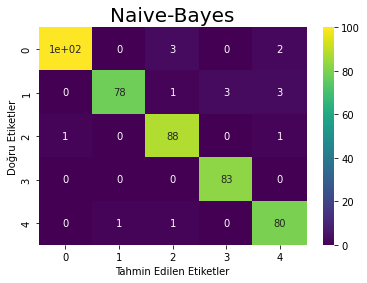

In [26]:
#TF-IDF kullanarak temizlenmiş verileri vektör haline getirme (NAİVE-BAYES ALGORİTMASI İÇİN)

def Vektor_Olustur(vec, X_train, X_test):    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    print('Vektör Oluşturma Tamamlandı.\n')
    return X_train_vec, X_test_vec


def Model_Olusturma(models, params, X_train, X_test, y_train, y_test):    
    for key in models.keys():
        
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        print("\n Isı Haritasında Doğruluk Ve Tahmin Karmaşıklık Matrisi ve Naive-Bayes Skorları: ")
        sns.heatmap(confusion_matrix(y_test,y_pred),cmap='viridis',annot=True);
        plt.title("Naive-Bayes", fontsize = 20)
        plt.xlabel("Tahmin Edilen Etiketler")
        plt.ylabel("Doğru Etiketler")
        # Accuracy-F1 vb skorlar
        print(gs.best_params_)
        print("\nPrecision Puanı: %1.3f \nRecall Puanı: %1.3f \nF1 Puanı: %1.3f\n" % (precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    return

modeller = {'Naive Bayes': MultinomialNB()}
parametreler = {'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] }}

# Haber Türlerini Sayısal Olarak Şifreleme
sifre = LabelEncoder()
data['haberTuru'] = sifre.fit_transform(data['haberTuru'])
turler = list(sifre.classes_)

# Train-test split ve vectorize işlemleri
X_train, X_test, y_train, y_test = train_test_split(data['haberIcerigi;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;'], data['haberTuru'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vektor_Olustur(TfidfVectorizer(), X_train, X_test)

Model_Olusturma(modeller, parametreler, X_train_vec, X_test_vec, y_train, y_test)